In [2]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd

def load_result_csv_files(directory):
    result_dfs = []
    file_paths = []
    for root, _, files in os.walk(directory):
        for filename in files:
            if filename.endswith("results.csv"):
                file_path = os.path.join(root, filename)
                relative_path = os.path.relpath(file_path, directory)
                df = pd.read_csv(file_path)
                result_dfs.append(df)
                file_paths.append(relative_path)
    return result_dfs, file_paths

directory_path = "/workdir/optimal-summaries-public/_models_ablation"
result_dfs, file_paths = load_result_csv_files(directory_path)
len(result_dfs)

15

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)


In [4]:
combined_df = pd.concat(result_dfs, ignore_index=True)
combined_df = combined_df[combined_df["Split"] == "test"].drop(columns=["Split"])
combined_df["Dataset"] = combined_df["Dataset"].replace({"mimic": "MIMIC", "spoken_arabic_digits": "SpokenArabicDigits", "tiselac": "Tiselac"})
combined_df["Model"] = combined_df["Model"].replace({"atomics_sum2atomics_False": "2Layers H2C", "atomics_sum2atomics_True": "2Layers H2A", "original": "Original", "shared_encode_time_dim_False": "Shared Time", "shared_encode_time_dim_True": "Shared Feature"})


## Full table

In [5]:
dataset = "SpokenArabicDigits" # Tiselac MIMIC SpokenArabicDigits
# combined_df[(combined_df["Dataset"] == dataset)] 


In [6]:
from scipy.stats import ttest_ind


for_p_values = combined_df[(combined_df["Model"] == "Original") & (combined_df["Dataset"] == "MIMIC")]
metrics = ['AUC', 'ACC', 'F1']

# Initialize dictionary to store p-values
p_values = {}

# Perform two-sample t-test for each combination of summaries, indicators, and metrics
for summary_val in [True, False]:
    for indicator_val in [True, False]:
        for metric in metrics:
            group1 = for_p_values.loc[(for_p_values["Summaries"] == summary_val) & (for_p_values["Indicators"] == indicator_val), metric]
            group2 = for_p_values.loc[(for_p_values["Summaries"] == summary_val) & (for_p_values["Indicators"] != indicator_val), metric]
            # group2 = for_p_values.loc[(for_p_values["Summaries"] != summary_val) & (for_p_values["Indicators"] == indicator_val), metric]
            _, p_value = ttest_ind(group1, group2)
            p_values[(summary_val, indicator_val, metric)] = p_value

# Create a DataFrame from the p-values dictionary
p_values_df = pd.DataFrame.from_dict(p_values, orient='index', columns=['p-value'])

# Reset index and rename the index levels
p_values_df = p_values_df.reset_index()
p_values_df = p_values_df.rename(columns={'level_0': 'Summaries', 'level_1': 'Indicators', 'level_2': 'Metric'})
p_values_df[['Summaries', 'Indicators', 'Metric']] = pd.DataFrame(p_values_df['index'].tolist(), index=p_values_df.index)
p_values_df = p_values_df.drop(columns=['index'])

# Display the DataFrame
display(p_values_df)

,p-value,Summaries,Indicators,Metric
0,0.413276,True,True,AUC
1,0.206905,True,True,ACC
2,0.185415,True,True,F1
3,0.413276,True,False,AUC
4,0.206905,True,False,ACC
5,0.185415,True,False,F1
6,0.063906,False,True,AUC
7,0.063648,False,True,ACC
8,0.045039,False,True,F1
9,0.063906,False,False,AUC


In [7]:
# Model,Indicators,Summaries,Dataset,Seed,Split,AUC,ACC,F1,Cutoff,Lower threshold,Upper threshold
per_set = combined_df.drop(columns=['Seed', "Cutoff", "Lower threshold", "Upper threshold"]).groupby(["Dataset", "Model", "Summaries", "Indicators"]).agg(["mean", "std"]).round(3)

float_format = "{:.2%}"

per_set[("AUC")] = per_set[("AUC", "mean")].map(float_format.format).map(lambda x: x.replace("%", "")) +" ± "+ per_set[("AUC", "std")].map(float_format.format)
per_set[("ACC")] = per_set[("ACC", "mean")].map(float_format.format).map(lambda x: x.replace("%", "")) +" ± "+ per_set[("ACC", "std")].map(float_format.format)
per_set[("F1")] = per_set[("F1", "mean")].map(float_format.format).map(lambda x: x.replace("%", "")) +" ± "+ per_set[("F1", "std")].map(float_format.format)
per_set.drop(columns=[("AUC", "mean"), ("ACC", "mean"), ("F1", "mean")], inplace=True)
per_set.columns = per_set.columns.droplevel(1)

with open('tex/Ablation per Dataset.tex', 'w') as f:
    # tex = per_set.to_latex(convert_css=True) # styler
    tex = per_set.to_latex(escape=True) #, float_format="{:.2%}".format)
    # tex = tex.replace('%', r'\%')
    f.write(tex)

per_set

AUC  \
Dataset            Model          Summaries Indicators                   
MIMIC              2Layers H2A    False     False        90.80 ± 0.20%   
                                            True         90.70 ± 1.40%   
                                  True      False        90.90 ± 0.60%   
                                            True         91.00 ± 0.60%   
                   2Layers H2C    False     False        91.00 ± 0.50%   
                                            True         91.00 ± 0.90%   
                                  True      False        86.80 ± 1.60%   
                                            True         87.70 ± 0.40%   
                   Original       False     False        90.80 ± 0.20%   
                                            True         91.40 ± 0.30%   
                                  True      False        87.50 ± 0.70%   
                                            True         86.90 ± 0.90%   
                   Shared Feature False     False        90.50 ± 0.10%   
                                            True         91.60 ± 0.20%   
                                  True      False        91.10 ± 0.40%   
                                            True         91.10 ± 0.20%   
                   Shared Time    False     False        90.80 ± 0.20%   
                                            True         91.50 ± 0.10%   
                                  True      False        91.30 ± 0.30%   
                                            True         91.80 ± 0.40%   
SpokenArabicDigits 2Layers H2A    False     False        99.70 ± 0.00%   
                                            True         99.70 ± 0.10%   
                                  True      False        99.40 ± 0.40%   
                                            True         98.10 ± 2.10%   
                   2Layers H2C    False     False        99.70 ± 0.00%   
                                            True         99.70 ± 0.10%   
                                  True      False        50.50 ± 0.60%   
                                            True         50.40 ± 0.30%   
                   Original       False     False        99.20 ± 0.20%   
                                            True         99.20 ± 0.10%   
                                  True      False        54.30 ± 6.40%   
                                            True         50.10 ± 0.00%   
                   Shared Feature False     False        99.90 ± 0.00%   
                                            True         99.90 ± 0.00%   
                                  True      False        51.20 ± 0.40%   
                                            True         51.40 ± 0.60%   
                   Shared Time    False     False        99.90 ± 0.00%   
                                            True         99.90 ± 0.00%   
                                  True      False        99.90 ± 0.00%   
                                            True         99.90 ± 0.00%   
Tiselac            2Layers H2A    False     False        95.60 ± 0.20%   
                                            True         95.40 ± 0.40%   
                                  True      False        96.00 ± 0.30%   
                                            True         96.30 ± 0.20%   
                   2Layers H2C    False     False        95.60 ± 0.20%   
                                            True         95.40 ± 0.40%   
                                  True      False       80.20 ± 26.20%   
                                            True        80.60 ± 26.50%   
                   Original       False     False        95.30 ± 0.10%   
                                            True         95.10 ± 0.20%   
                                  True      False       65.50 ± 26.80%   
                                            True        81.10 ± 26.90%   
                   Shared Feature False     False        96.00 ± 0.10% 

## Figure


In [7]:
# Model,Indicators,Summaries,Dataset,Seed,Split,AUC,ACC,F1,Cutoff,Lower threshold,Upper threshold

dataset = "SpokenArabicDigits" # Tiselac MIMIC SpokenArabicDigits
per_set = combined_df[(combined_df["Dataset"] == dataset)] 
per_set = per_set.drop(columns=['Seed', "Cutoff", "Lower threshold", "Upper threshold", "Dataset"]).groupby(["Model", "Summaries", "Indicators"]).agg(["mean", "std"]).round(3)


per_set

AUC           ACC            F1       
                                      mean    std   mean    std   mean    std
Model          Summaries Indicators                                          
2Layers H2A    False     False       0.997  0.000  0.941  0.003  0.941  0.003
                         True        0.997  0.001  0.946  0.004  0.946  0.004
               True      False       0.994  0.004  0.921  0.024  0.921  0.025
                         True        0.981  0.021  0.848  0.101  0.846  0.104
2Layers H2C    False     False       0.997  0.000  0.941  0.003  0.941  0.003
                         True        0.997  0.001  0.946  0.004  0.946  0.004
               True      False       0.505  0.006  0.105  0.006  0.027  0.010
                         True        0.504  0.003  0.106  0.005  0.030  0.008
Original       False     False       0.992  0.002  0.895  0.005  0.895  0.006
                         True        0.992  0.001  0.894  0.005  0.893  0.005
               True      False       0.543  0.064  0.133  0.042  0.047  0.022
                         True        0.501  0.000  0.101  0.001  0.020  0.002
Shared Feature False     False       0.999  0.000  0.965  0.002  0.965  0.002
                         True        0.999  0.000  0.973  0.003  0.973  0.003
               True      False       0.512  0.004  0.112  0.004  0.039  0.006
                         True        0.514  0.006  0.114  0.005  0.042  0.007
Shared Time    False     False       0.999  0.000  0.965  0.005  0.965  0.005
                         True        0.999  0.000  0.968  0.003  0.968  0.003
               True      False       0.999  0.000  0.966  0.001  0.966  0.001
                         True        0.999  0.000  0.969  0.002  0.969  0.002

AUC_mean                                      \
Model                2Layers H2A 2Layers H2C Original Shared Feature   
Indicators Summaries                                                   
False      False           0.997       0.997    0.992          0.999   
           True            0.994       0.505    0.543          0.512   
True       False           0.997       0.997    0.992          0.999   
           True            0.981       0.504    0.501          0.514   

                                     AUC_std                       \
Model                Shared Time 2Layers H2A 2Layers H2C Original   
Indicators Summaries                                                
False      False           0.999       0.000       0.000    0.002   
           True            0.999       0.004       0.006    0.064   
True       False           0.999       0.001       0.001    0.001   
           True            0.999       0.021       0.003    0.000   

                                                 
Model                Shared Feature Shared Time  
Indicators Summaries                             
False      False              0.000         0.0  
           True               0.004         0.0  
True       False              0.000         0.0  
           True               0.006         0.0

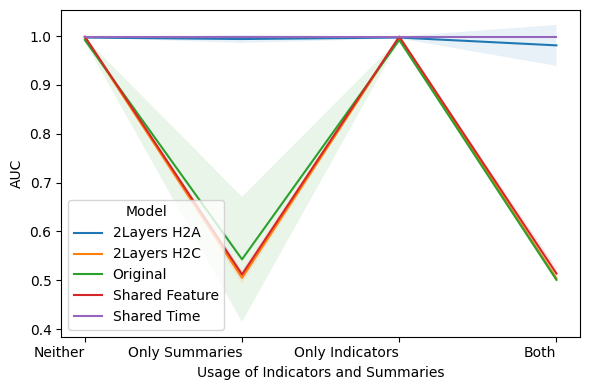

In [8]:
df = per_set.copy()

df.columns = ['_'.join(col).strip() for col in df.columns.values]
df = df.reset_index()
import matplotlib.pyplot as plt

auc_df = df[['Model', "Indicators", 'Summaries', 'AUC_mean', 'AUC_std']]

pivot_df = auc_df.pivot(index=['Indicators', 'Summaries'], columns='Model', values=['AUC_mean', 'AUC_std'])
display(pivot_df)

fig, ax = plt.subplots(figsize=(6, 4))

for column in pivot_df['AUC_mean'].columns:
    ax.plot(range(len(pivot_df.index)), pivot_df['AUC_mean'][column], label=column)
    ax.fill_between(range(len(pivot_df.index)), 
                    pivot_df['AUC_mean'][column] - 2 * pivot_df['AUC_std'][column], 
                    pivot_df['AUC_mean'][column] + 2 * pivot_df['AUC_std'][column], 
                    alpha=0.1)

# plt.title('AUC by Model and Summaries')
plt.xlabel('Usage of Indicators and Summaries')
plt.ylabel('AUC')
# plt.ylim(0.65, 1.0)
custom_labels = ['Neither', 'Only Summaries', 'Only Indicators', 'Both']
plt.xticks(ticks=range(len(pivot_df.index)), labels=custom_labels, rotation=0, ha='right')
plt.legend(title='Model')
plt.tight_layout()
plt.savefig("fig/Ablation_"+dataset+".pdf", format='pdf')
plt.show()


## Grouped

In [9]:
grouped = combined_df.drop(columns=["Seed", "Dataset", "Cutoff", "Lower threshold", "Upper threshold"]).groupby(["Model", "Indicators", "Summaries"]).agg(["mean", "std"]).round(3)#.reset_index()

float_format = "{:.2%}"

grouped[("AUC")] = grouped[("AUC", "mean")].map(float_format.format).map(lambda x: x.replace("%", "")) +" ± "+ grouped[("AUC", "std")].map(float_format.format)
grouped[("ACC")] = grouped[("ACC", "mean")].map(float_format.format).map(lambda x: x.replace("%", "")) +" ± "+ grouped[("ACC", "std")].map(float_format.format)
grouped[("F1")] = grouped[("F1", "mean")].map(float_format.format).map(lambda x: x.replace("%", "")) +" ± "+ grouped[("F1", "std")].map(float_format.format)
grouped.drop(columns=[("AUC", "mean"), ("ACC", "mean"), ("F1", "mean")], inplace=True)
grouped.columns = grouped.columns.droplevel(1)

with open('tex/Ablation Grouped.tex', 'w') as f:
    tex = grouped.to_latex(escape=True) #, float_format="{:.2%}".format)
    # tex = tex.replace('%', r'\%')
    f.write(tex)

grouped

# best auc 0.966000 acc 0.871000 f1 0.857000

AUC             ACC  \
Model          Indicators Summaries                                   
2Layers H2A    False      False       95.40 ± 3.90%   83.00 ± 9.60%   
                          True        95.50 ± 3.70%   82.80 ± 8.30%   
               True       False       95.30 ± 4.00%  83.50 ± 10.30%   
                          True        95.10 ± 3.40%   80.80 ± 7.20%   
2Layers H2C    False      False       95.40 ± 3.80%   83.10 ± 9.60%   
                          True       72.50 ± 21.30%  48.90 ± 36.70%   
               True       False       95.40 ± 3.80%  83.30 ± 10.20%   
                          True       72.90 ± 21.70%  49.40 ± 37.00%   
Original       False      False       95.10 ± 3.60%   81.30 ± 8.00%   
                          True       69.10 ± 20.10%  43.60 ± 37.30%   
               True       False       95.20 ± 3.40%   81.30 ± 8.40%   
                          True       72.70 ± 21.80%  50.00 ± 37.90%   
Shared Feature False      False       95.50 ± 4.10%   84.40 ± 9.80%   
                          True       79.60 ± 21.40%  56.40 ± 34.20%   
               True       False       95.80 ± 3.60%  85.20 ± 10.20%   
                          True       79.60 ± 21.30%  56.50 ± 34.10%   
Shared Time    False      False       95.60 ± 4.00%   84.70 ± 9.70%   
                          True        96.10 ± 3.80%   86.20 ± 8.10%   
               True       False       95.80 ± 3.60%   85.10 ± 9.80%   
                          True        96.30 ± 3.60%   86.50 ± 8.20%   

                                                 F1  
Model          Indicators Summaries                  
2Layers H2A    False      False      81.90 ± 11.50%  
                          True       81.50 ± 10.60%  
               True       False      82.10 ± 12.40%  
                          True        79.20 ± 9.40%  
2Layers H2C    False      False      82.00 ± 11.50%  
                          True       44.40 ± 40.40%  
               True       False      82.00 ± 12.40%  
                          True       45.00 ± 40.50%  
Original       False      False      80.30 ± 10.00%  
                          True       38.30 ± 41.50%  
               True       False      80.20 ± 10.40%  
                          True       45.40 ± 41.70%  
Shared Feature False      False      83.10 ± 11.90%  
                          True       52.70 ± 37.20%  
               True       False      83.80 ± 12.30%  
                          True       52.70 ± 37.00%  
Shared Time    False      False      83.30 ± 11.90%  
                          True       84.80 ± 10.00%  
               True       False      83.90 ± 11.70%  
                          True       85.00 ± 10.30%